In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../..')

In [3]:
from replay.preprocessing.filters import MinCountFilter
from replay.splitters import TimeSplitter, LastNSplitter, ColdUserRandomSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

/opt/miniconda3/envs/tst/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import random
import numpy as np

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [5]:
from rs_datasets import MovieLens

In [6]:
movielens = MovieLens("20m")
interactions = movielens.ratings

In [7]:
interactions['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 138493
Number of unique items: 26744


In [9]:
pd.to_datetime(interactions['timestamp'], unit='s').describe()

/tmp/ipykernel_1773441/4186389301.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(interactions['timestamp'], unit='s').describe()


count                20000263
unique               15351121
top       1996-03-01 00:00:00
freq                      643
first     1995-01-09 11:46:44
last      2015-03-31 06:40:02
Name: timestamp, dtype: object

In [10]:
pd.to_datetime(interactions['timestamp'], unit='s')

0          2005-04-02 23:53:47
1          2005-04-02 23:31:16
2          2005-04-02 23:33:39
3          2005-04-02 23:32:07
4          2005-04-02 23:29:40
                   ...        
20000258   2009-11-13 15:42:00
20000259   2009-12-03 18:31:48
20000260   2009-12-07 18:10:57
20000261   2009-11-13 15:42:24
20000262   2009-10-17 20:25:36
Name: timestamp, Length: 20000263, dtype: datetime64[ns]

In [11]:
interactions.head()

,user_id,item_id,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


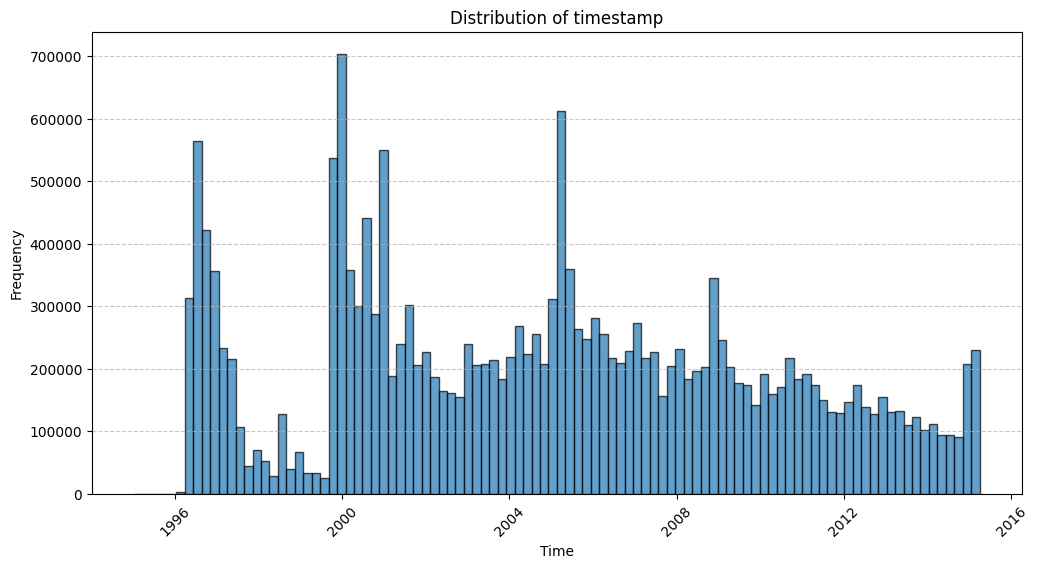

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 's', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [13]:
# Фильтруем данные по минимальному рейтингу
interactions = interactions[
                interactions['rating']
                > 3
            ]

In [14]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 5


In [15]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='s'))
print(pd.to_datetime(interactions.timestamp.max(), unit='s'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.2f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.2f}")

(12180742, 4)
1995-01-09 11:46:44
2015-03-31 06:40:02
Interaction Density: 0.57%
Mean Sequence Length: 88.22


In [16]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 138078
Number of unique items: 15405


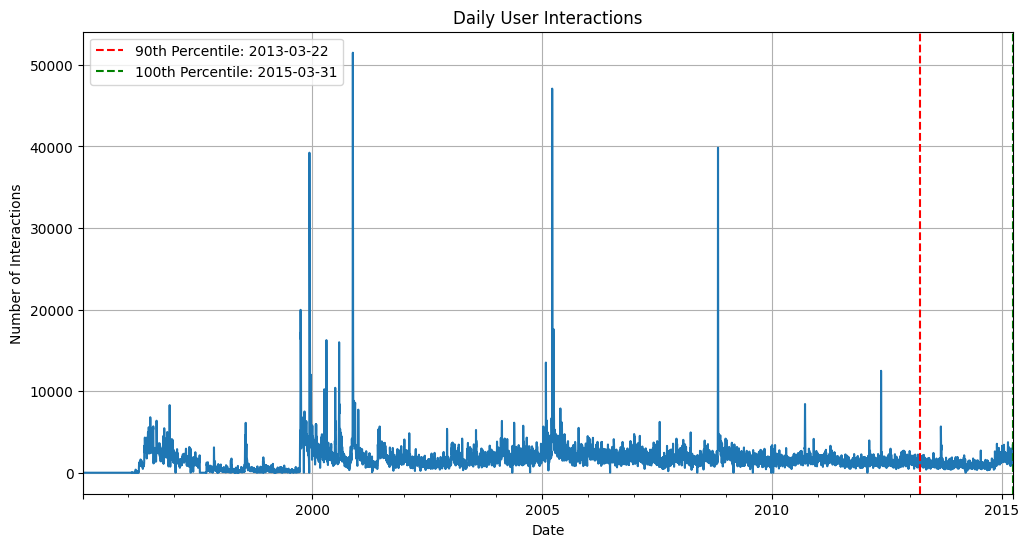

In [17]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='s')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    global_splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=False,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )
    val_splitter = ColdUserRandomSplitter(
        test_size=0.1,
        drop_cold_items=True,
        query_column="user_id",
        seed=42,
    )
    loo_splitter = LastNSplitter(
        N=1,
        drop_cold_users=True,
        drop_cold_items=False,
        divide_column="user_id",
        query_column="user_id",
        strategy="interactions",
    )

    train, raw_test = global_splitter.split(interactions)
    train_events, val = val_splitter.split(train)
    test_users = set(raw_test['user_id']) - set(val['user_id'])
    test_events, test_gt = loo_splitter.split(
        interactions[
            (interactions['user_id'].isin(test_users))
            & interactions['item_id'].isin(train_events['item_id'].unique())
        ]
    )
    validation_events, validation_gt = loo_splitter.split(val)
    test_gt = test_gt[test_gt['item_id'].isin(train_events['item_id'])]
    test_gt_correct = test_gt[test_gt['user_id'].isin(test_events['user_id'])]
    test_gt = test_gt[test_gt['user_id'].isin(train_events['user_id'])]
    print(
            f"Distribution of seq_len in validation:\n{validation_events.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    print(
        f"Distribution of seq_len in validation gt:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_events.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt correct:\n{test_gt_correct.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    12622.000000
mean        83.944304
std        124.871258
min          2.000000
25%         19.000000
50%         39.000000
75%         96.000000
max       2392.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation gt:
count    12622.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    16123.000000
mean       144.817404
std        217.494586
min          2.000000
25%         26.000000
50%         62.000000
75%        172.000000
max       3939.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test gt correct:
count    16123.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: item_id, dtype: float64.
Distribution of seq_len in test gt:
count    4281.0
mean        1.0
std         0.0
min       

In [21]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    train_val_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=pd.concat([train_events, validation_events], ignore_index=True),
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        train_val_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, train_val_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [22]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    train_val_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_val_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, train_val_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [23]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 11709
Number of unique query_ids: 12622


count    12622.000000
mean        83.944304
std        124.871258
min          2.000000
25%         19.000000
50%         39.000000
75%         96.000000
max       2392.000000
Name: item_id_seq, dtype: float64

In [24]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
print(sequence_lengths.describe())
print(splits['validation_gt'].shape)

Number of unique item_ids: 3507
Number of unique query_ids: 12622
count    12622.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: item_id_seq, dtype: float64
(12622, 4)


In [25]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 13766
Number of unique query_ids: 4281


count    4281.000000
mean      339.063537
std       313.677402
min         4.000000
25%       136.000000
50%       252.000000
75%       444.000000
max      3939.000000
Name: item_id_seq, dtype: float64

In [26]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
print(splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe())
print(splits['test_gt'].shape)

Number of unique item_ids: 2002
Number of unique query_ids: 4281
count    4281.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: item_id, dtype: float64
(4281, 4)


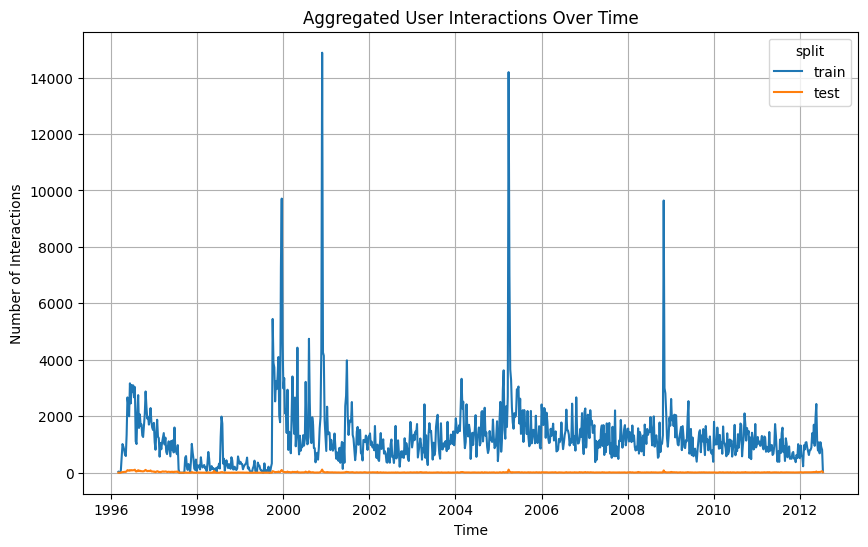

In [27]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='s')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

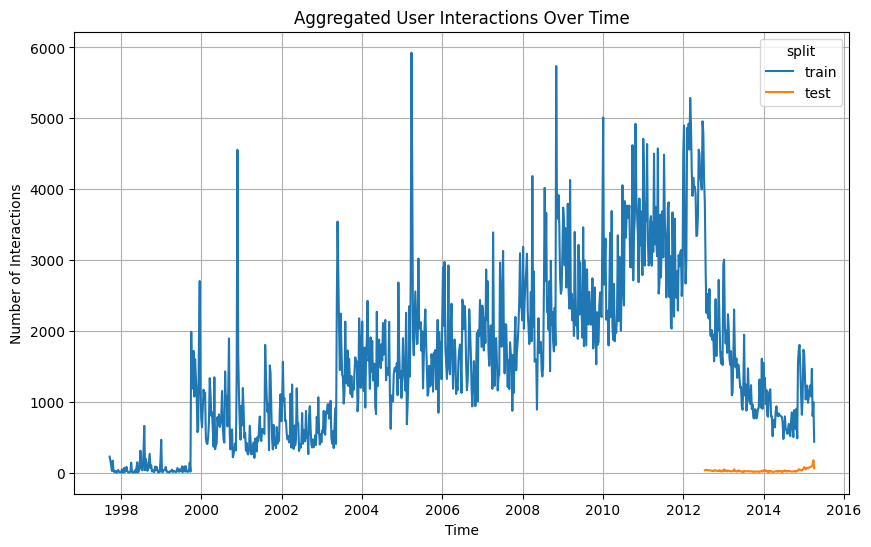

In [28]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

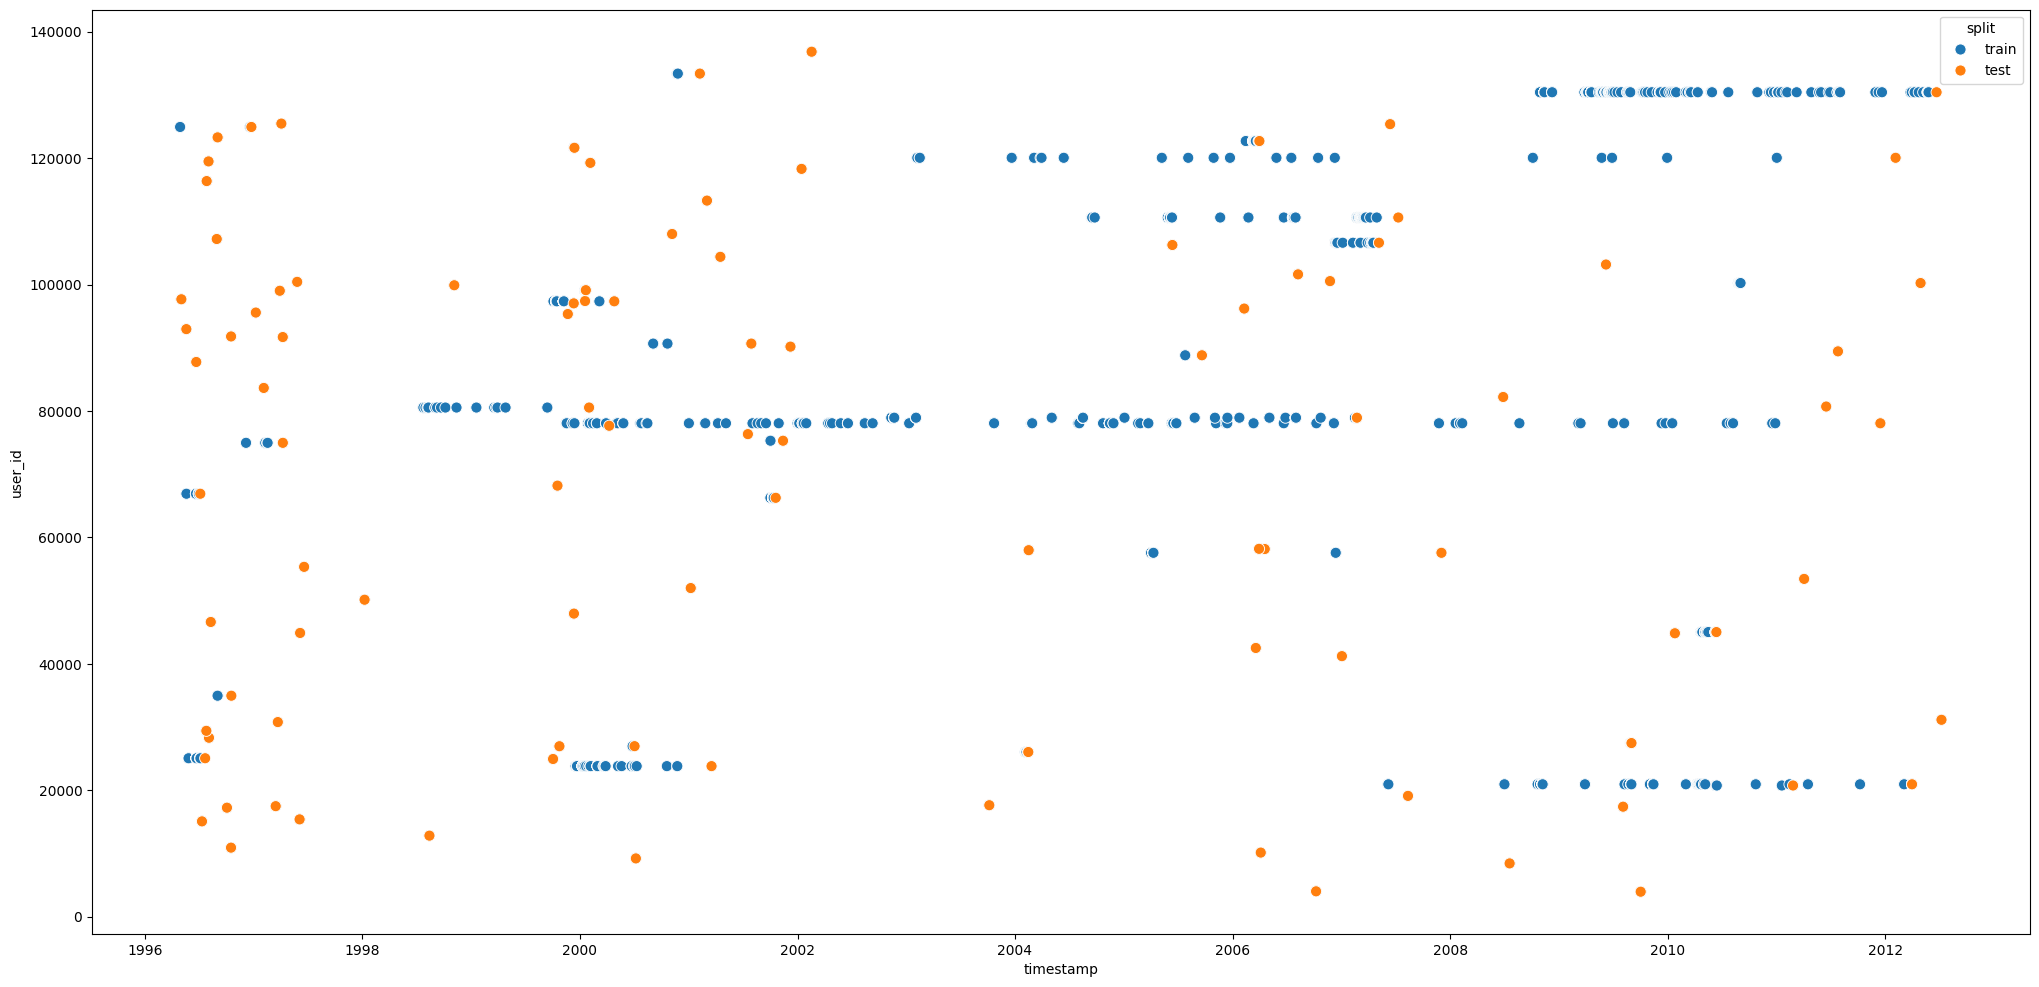

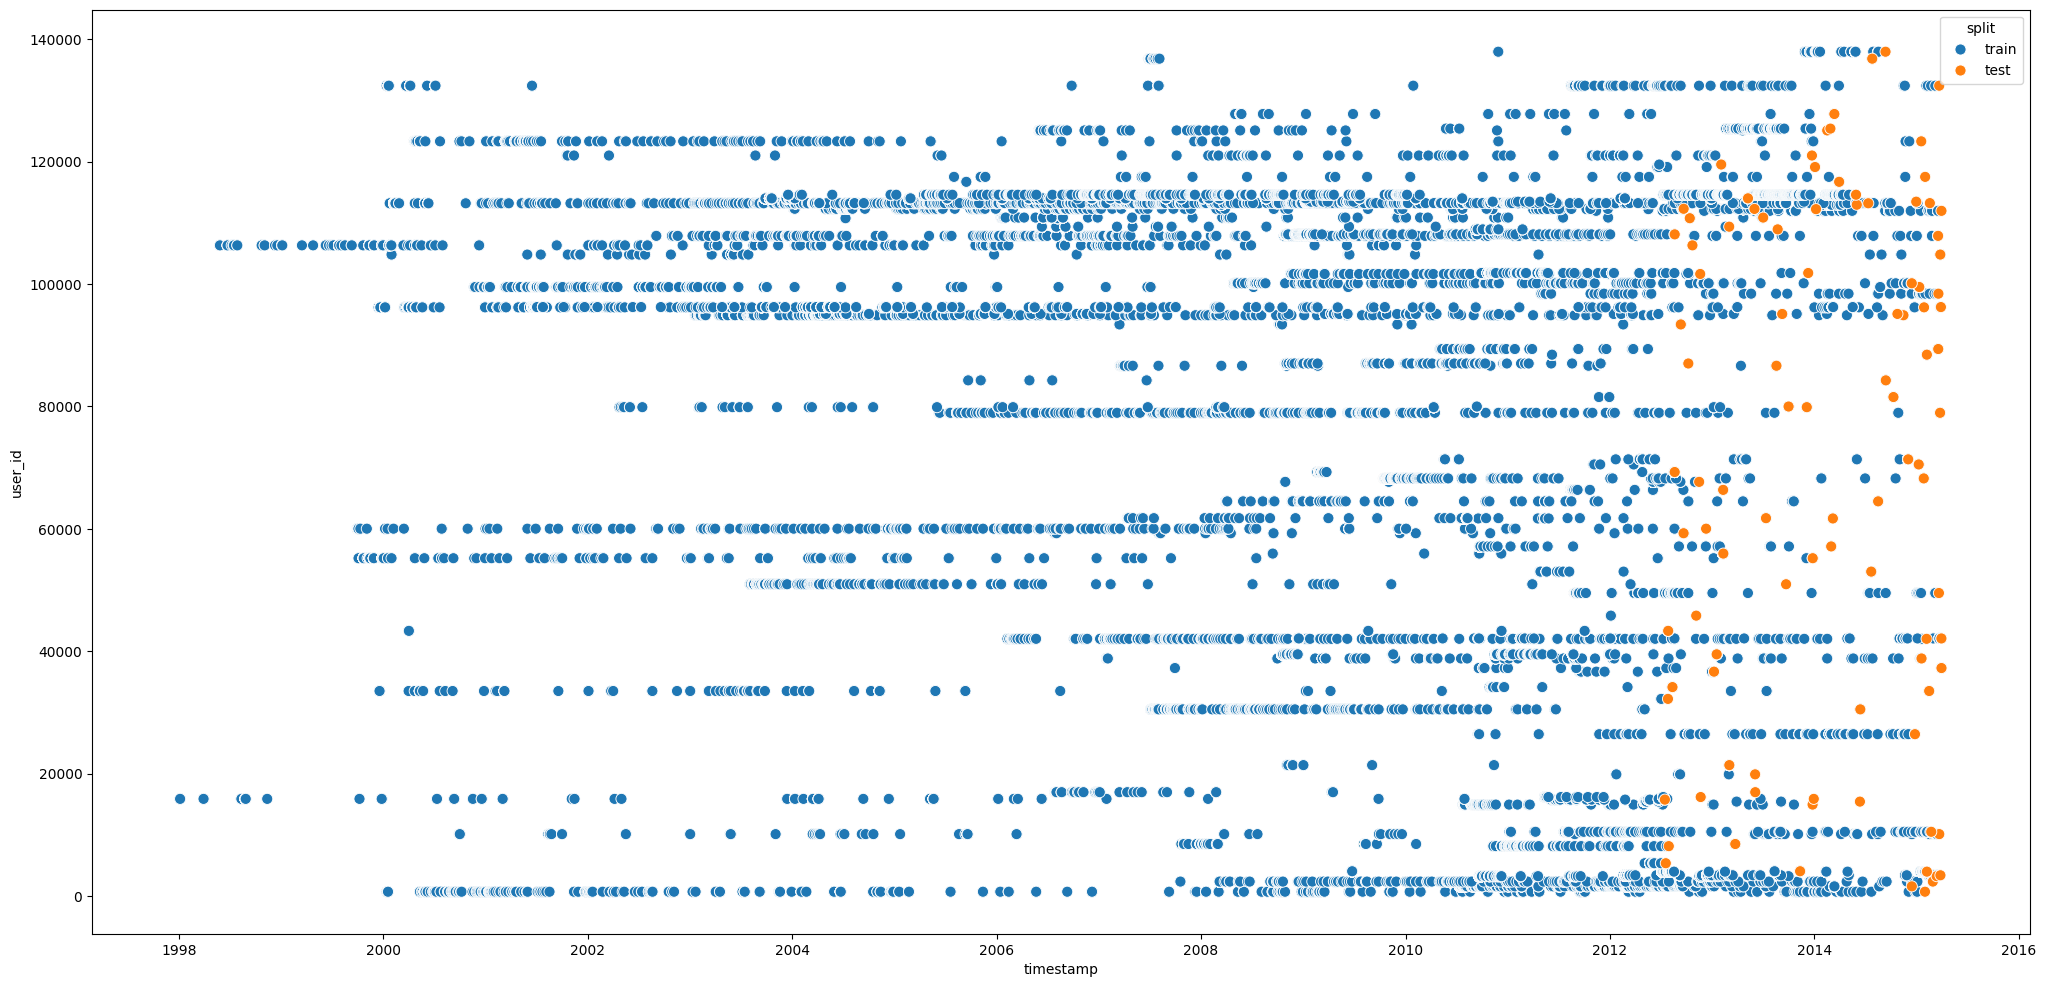

In [29]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='s')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)

In [30]:
splits['train'][splits['train'].user_id.isin(test_gt.user_id)]

,user_id,item_id,rating,timestamp
1095612,79366,1407,4.0,874357760
1095613,79366,260,5.0,874357917
1095614,79366,36,4.0,874357965
1095615,79366,800,4.0,874357996
1095616,79366,32,4.0,874358033
...,...,...,...,...
10962662,131579,90888,4.5,1341890264
10962663,131579,88129,4.5,1341890273
10962664,83081,92535,4.5,1341890531
10962665,65250,5858,3.5,1341890943


In [31]:
len(set(splits['train'].item_id))

13990

In [32]:
len(set(val_gt.item_id))

3507

In [33]:
len(set(test_gt.item_id)) 

2002

In [34]:
len(set(test_gt.item_id) - set(val_gt.item_id))

734

In [35]:
splits['train'][splits['train'].item_id.isin(set(test_gt.item_id) - set(val_gt.item_id))]

,user_id,item_id,rating,timestamp
438,112497,369,4.0,825638400
43769,80426,678,5.0,831170748
96874,24709,369,5.0,832813317
98642,109121,369,5.0,832859805
99606,32864,369,4.0,832871805
...,...,...,...,...
10962561,54803,59727,4.0,1341883108
10962589,82418,95167,3.5,1341886181
10962619,52064,4427,3.5,1341886583
10962652,52064,84847,4.5,1341887278


In [36]:
len(set(val_gt.item_id) - set(test_gt.item_id))

2239

In [37]:
splits['train'][splits['train'].item_id.isin(set(val_gt.item_id) - set(test_gt.item_id))]

,user_id,item_id,rating,timestamp
3,99851,52,4.0,822873600
4,99851,45,4.0,822873600
5,85252,2,4.0,822873600
8,85252,7,5.0,822873600
9,85252,10,5.0,822873600
...,...,...,...,...
10962638,52064,3362,4.0,1341886991
10962642,52064,4783,4.0,1341887040
10962644,52064,3037,4.0,1341887051
10962647,52064,36,4.0,1341887120


In [38]:
test_gt

,user_id,item_id,rating,timestamp
7049,60,1285,4.5,1351459007
26081,208,1097,4.5,1396617059
31641,248,1704,4.0,1414610153
34716,271,2918,4.0,1409972146
35887,279,709,4.5,1398230676
...,...,...,...,...
19981543,138343,34437,3.5,1394455292
19988530,138406,1299,4.5,1420840880
19992351,138435,4223,4.0,1405816293
19992599,138436,27773,3.5,1346196035


In [39]:
test_gt[test_gt.item_id.isin(val_gt.item_id.unique())]

,user_id,item_id,rating,timestamp
7049,60,1285,4.5,1351459007
26081,208,1097,4.5,1396617059
31641,248,1704,4.0,1414610153
34716,271,2918,4.0,1409972146
35887,279,709,4.5,1398230676
...,...,...,...,...
19981543,138343,34437,3.5,1394455292
19988530,138406,1299,4.5,1420840880
19992351,138435,4223,4.0,1405816293
19992599,138436,27773,3.5,1346196035
